#### imports

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import requests
import os
import pickle
import copy


import mne
import pyriemann.spatialfilters as sfilters
# from CSP import covarianceMatrix
from sklearn.decomposition import FastICA

from sklearn.svm import NuSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import FastICA

from sklearn.model_selection import GridSearchCV,cross_val_predict, StratifiedShuffleSplit
import optuna

from sklearn.metrics import mean_squared_error,accuracy_score,f1_score,roc_auc_score

d:\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt

#### important variables

In [3]:
electrodes=['FC3','FCz','FC4','C5','C3','C1','Cz','C2','C4','C6','CP3','CP1','CPz','CP2','CP4','Pz']
fs=256
dt=8
dataset=dict().fromkeys(['P1','P2','P3'])

In [4]:
# dec_tree_params = {
#     'criterion':['gini', 'entropy', 'log_loss'],
#     # 'splitter':['best','random'],
#     'max_depth':list(range(1,17)),
#     # 'min_impurity_decrease':np.arange(0,0.6,0.01).tolist()
# }
# NuSVC_params={
#     'nu':np.arange(0,1,0.05).tolist(),
#     'kernel':['linear','poly','rbf'],
#     'gamma':['scale','auto']
# }
# SVC_params={
#     'C':np.arange(0,1,0.05).tolist(),
#     'kernel':['linear','poly','rbf'],
#     'gamma':['scale','auto']
# }
# rand_for_params = {
#     'criterion':['gini', 'entropy', 'log_loss'],
#     'max_depth':list(range(1,17)),
#     # 'min_impurity_decrease':np.arange(0,0.6,0.01).tolist()
# }

In [5]:
def dec_tree_params(trial):
    _params={
        'max_depth':trial.suggest_int(**{'name':'max_depth','low':2,'high':16}),
        'min_impurity_decrease':trial.suggest_int(**{'name':'min_impurity_decrease','low':0,'high':0.1}),
        'criterion':trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
        'splitter':trial.suggest_categorical('splitter',['best','random'])
    }
    return _params
def NuSVC_params(trial):
    _params={
        # 'nu':trial.suggest_int(**{'name':'nu','low':0.1,'high':0.9}),
        'kernel':trial.suggest_categorical('kernel',['linear','poly','rbf']),
        'gamma':trial.suggest_categorical('gamma',['scale','auto'])
    }
    return _params
def SVC_params(trial):
    _params={
        # 'C':trial.suggest_int(**{'name':'nu','low':0.1,'high':1}),
        'kernel':trial.suggest_categorical('kernel',['linear','poly','rbf']),
        'gamma':trial.suggest_categorical('gamma',['scale','auto'])
    }
    return _params

def rand_for_params(trial):
    _params={
        'max_depth':trial.suggest_int(**{'name':'max_depth','low':2,'high':17}),
        'min_impurity_decrease':trial.suggest_int(**{'name':'min_impurity_decrease','low':0,'high':0.1}),
        'criterion':trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
    }
    return _params

#### functions

In [168]:
def trigger_stamps(trig):
    trig_stamps=list()
    for i in range(trig.shape[0]):
        if (i==0) or (trig[i] != trig[i-1]):
            trig_stamps.append(i)
    return np.array(trig_stamps).reshape(len(trig_stamps),1)

def partition_trials(matData):
    global dt,fs,electrodes

    y=matData['trig']
    stamps=trigger_stamps(matData['trig'])

    stamps=stamps[y[stamps[:,0]]!=0]
    y=y[stamps]
    y[y==-1]=0

    X=np.empty((0,len(electrodes),fs*dt))

    for t in stamps:
        new=matData['y'][t:t+(dt*fs),:].T.reshape(1,len(electrodes),dt*fs)
        X=np.vstack((X,new))
    return {'X':X,'y':y}

def trials_covariance(X,method=np.cov):
    cov_matx=np.empty((X.shape[0],X.shape[1],X.shape[1]))
    for i,x in enumerate(X):
        cov_matx[i,:,:]=method(x)
    return cov_matx

def trials_component_analysis(X,method_class):
    matx=np.empty((X.shape[0],method_class.n_comp,X.shape[2]))
    for i,trial in enumerate(X):
        matx[i,:,:]=method_class._ca.fit_transform(X[i,:,:].T).T
    print(matx.shape)
    return matx

def trials_stft(x,wsize,tstep,verbose=False):
    X=copy.deepcopy(x)
    for c,i in enumerate(X):
        if c==0:
            res=np.transpose(mne.time_frequency.stft(i,wsize,verbose=False),(2,0,1))
            res=res.reshape(1,res.shape[0],res.shape[1],res.shape[2])
        else:
            nxt=np.transpose(mne.time_frequency.stft(i,wsize,verbose=False),(2,0,1))
            nxt=nxt.reshape(1,nxt.shape[0],nxt.shape[1],nxt.shape[2])
            res=np.vstack((
                res,
               nxt
            ))
    return res

class filter:
    def __init__(self,lfreq,hfreq,fs):
        self.filter_=mne.decoding.TemporalFilter(lfreq,hfreq,2*fs)

    def fit(self):
        return self.filter_

    def fit_transform(self,test):
        self.fit()
        return self.transform(test)

    def transform(self,test):
        return self.filter_.transform(copy.deepcopy(test['X']))

class flatten:
    def __init__(self):
        pass

    def fit(self):
        return self

    def fit_transform(self,test):
        self.fit()
        return self.transform(test)

    def transform(self,data):
        data=copy.deepcopy(data)
        if data['X'].ndim==3:
            return data['X'].reshape(data['X'].shape[0],data['X'].shape[-1]*data['X'].shape[-2])
        if data['X'].ndim==2:
            return data['X'].reshape(data['X'].shape[0],data['X'].shape[-1])

class stft:
    def __init__(self,wsize,verbose=None):
        self.stft=mne.time_frequency.stft
        self.wsize=wsize
        self.tstep=int(self.wsize/2)
        self.fit_transform=self.transform

    def fit(self):return self

    def fit_transform(self,x):
        self.fit()
        self.transform(x)

    def transform(self,x):
        return trials_stft(x,self.wsize,self.tstep,verbose=False)


class ica:
    def __init__(self,n_comp):
        self._ca=FastICA(n_components=n_comp)
        self.n_comp=n_comp

    def fit(self,train):
        # trials_component_analysis(train['X'],self)
        return self._ca

    def fit_transform(self,train):
        return trials_component_analysis(train['X'],self)

    def transform(self,test):
        return trials_component_analysis(test['X'],self)

class csp:
    def __init__(self,n_filter,cov_method=np.cov):
        self._csp=sfilters.CSP(nfilter=n_filter)
        self.cov_method=cov_method
    
    def fit(self,train):
        print(train['y'].shape,train['X'].shape,trials_covariance(train['X'],self.cov_method).shape)
        self._csp.fit(trials_covariance(train['X'],self.cov_method),train['y'])
        return self._csp

    def fit_transform(self,train):
        self.fit(train)
        return self.transform(train)
    
    def transform(self,test):
        c=self._csp.transform(trials_covariance(test['X'],self.cov_method))
        if c.shape[1]==2:
            return c[:,0:2]
        elif c.shape[1]==3:
            return c[:,0:3]
        else:
            return np.hstack((c[:,0:2],c[:,-2:]))

class classifier:
    def __init__(self,method,grid_params):
        self.grid=copy.deepcopy(method)
        self.clf=method
        self.method=copy.deepcopy(method)
        self._params=grid_params
        self._best_params=0
    
    def fit(self,train,test=None):
        # grid=GridSearchCV(self.grid,self._params,cv=4,scoring='f1',verbose=0,n_jobs=-1)
        # grid.fit(train['X'],train['y'])
        # self._best_params=grid.best_params_

        def objective(trial):
            clf=self.grid(**self._params(trial))
            clf.fit(train['X'],train['y'])
            if test==None:
                return clf.score(train['X'],train['y'])
            else:
                return clf.score(test['X'],test['y'])
        study=optuna.create_study(direction='maximize')
        study.optimize(objective,n_trials=10)
        trial=study.best_trial
        self._best_params=trial.params

        self.method=copy.deepcopy(self.clf)(**self._best_params)
        self.method.fit(train['X'],train['y'])
        return self.method

    def fit_transform(self,train):
        self.fit(train)
        return self.transform(train)
    
    def transform(self,test):
        return self.method.predict(test['X'])

    def score(self,test,method):
        pred=self.transform(test)
        return method(test['y'],pred)

class pipeline:
    def __init__(self,transformrers):
        self.transformers=transformrers
    
    def fit(self,train,test=None):
        r=copy.deepcopy(train)
        for transformer in self.transformers[0:-1]:
            r={'X':transformer.fit_transform(r),'y':r['y']}
        self.transformers[-1].fit(r)

        return self

    def fit_transform(self,train):
        self.fit(train)
        return self.transform(train)

    def transform(self,data):
        r=copy.deepcopy(data)
        for transformer in self.transformers[0:-1]:
            r={'X':transformer.transform(r),'y':r['y']}
        return self.transformers[-1].transform(r)

    def score(self,test,method):
        r=copy.deepcopy(test)
        for transformer in self.transformers[0:-1]:
            r={'X':transformer.transform(r),'y':r['y']}
        return self.transformers[-1].score(r,method)

def train_features_models(_pipeline):
    df=dict().fromkeys(['P1','P2','P3'])
    for p in df.keys():
        df[p]=dict().fromkeys(['pre','post'])
        for s in dataset[p].keys():
            df[p][s]=_pipeline.fit(dataset[p][s]['train'])
    return df

def get_test_features(models):
    df=dict().fromkeys(['P1','P2','P3'])
    for p in df.keys():
        df[p]=dict().fromkeys(['pre','post'])
        for s in['pre','post']:
            if isinstance(models,dict):
                df[p][s]=models[p][s].transform(dataset[p][s]['test'])
            else:
                df[p][s]=models.transform(dataset[p][s]['test'])
    return df

def csp_features_plot(features,x,y):
    fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(20,10))

    for r,p in enumerate(features.keys()):
        for c,s in enumerate(features[p].keys()):
            ax[r,c].scatter(
                features[p][s][(dataset[p][s]['test']['y']==0).reshape(80),x],
                features[p][s][(dataset[p][s]['test']['y']==0).reshape(80),y]
                )
            ax[r,c].scatter(
                features[p][s][(dataset[p][s]['test']['y']==1).reshape(80),x],
                features[p][s][(dataset[p][s]['test']['y']==1).reshape(80),y]
                )

def results(df,mthd):
    for p in dataset.keys():
        for s in dataset[p].keys():
            clf=copy.deepcopy(mthd)
            X=np.vstack((
                dataset[p][s]['train']['X'],
                dataset[p][s]['test']['X']
            ))
            y=np.vstack((
                dataset[p][s]['train']['y'],
                dataset[p][s]['test']['y']
            ))
            splitter=StratifiedShuffleSplit(n_splits=1, test_size=0.4,random_state=1)
            tris=[]
            testis=[]
            for train_index,test_index in splitter.split(X,y):
                tris.append(train_index)
                testis.append(test_index)
            train={'X':X[tris,:,:],'y':y[tris]}
            train['X']=train['X'].reshape(
                train['X'].shape[1],
                train['X'].shape[2],
                train['X'].shape[3],
            )
            train['y']=train['y'].reshape(train['y'].shape[1])
            test={'X':X[testis,:,:],'y':y[testis]}
            test['X']=test['X'].reshape(
                test['X'].shape[1],
                test['X'].shape[2],
                test['X'].shape[3],
            )
            test['y']=test['y'].reshape(test['y'].shape[1])
            # print([train['X'].shape,train['y'].shape])
            clf.fit(train)

            # clf.fit(dataset[p][s]['train'],test=dataset[p][s]['test'])
            df.loc[p][s]=clf.score(dataset[p][s]['test'],accuracy_score)

            # df.loc[p][s]=clf.score(test,accuracy_score)

def clf_result(df,mthd,models):
    for p in models.keys():
        for s in models[p].keys():
            mthd.fit(
                {
                    'X':models[p][s].transform(dataset[p][s]['train']),
                    'y':dataset[p][s]['train']['y']
                }
            )
            df.loc[p][s]=mthd.score({
                'X':models[p][s].transform(dataset[p][s]['test']),
                'y':dataset[p][s]['test']['y']
            },accuracy_score)
    return df

# def nn_result(df,mthd,models):
#     for p in models.keys():
#         for s in models[p].keys():
#             mthd.fit(
#                 {
#                     'X':models.transform(dataset[p][s]['train']),
#                     'y':dataset[p][s]['train']['y']
#                 }
#             )
#             df.loc[p][s]=mthd.score({
#                 'X':models.transform(dataset[p][s]['test']),
#                 'y':dataset[p][s]['test']['y']
#             },accuracy_score)
#     return df

#### extract data of interest

In [8]:
for p in dataset.keys():
    dataset[p]={
        'pre':{
            'train':partition_trials(scipy.io.loadmat('stroke/'+p+'_pre_training.mat')),
            'test':partition_trials(scipy.io.loadmat('stroke/'+p+'_pre_test.mat'))
        },
        'post':{
            'train':partition_trials(scipy.io.loadmat('stroke/'+p+'_post_training.mat')),
            'test':partition_trials(scipy.io.loadmat('stroke/'+p+'_post_test.mat'))
        },
    }

# CSP

#### model

In [74]:
_csp_pipeline=pipeline([
    filter(0,30,256),
    csp(n_filter=16)
])

_csp_models=train_features_models(_csp_pipeline)
_csp_features=get_test_features(_csp_models)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.1s finished


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz


[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.1s finished


- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.2s finished


#### plot

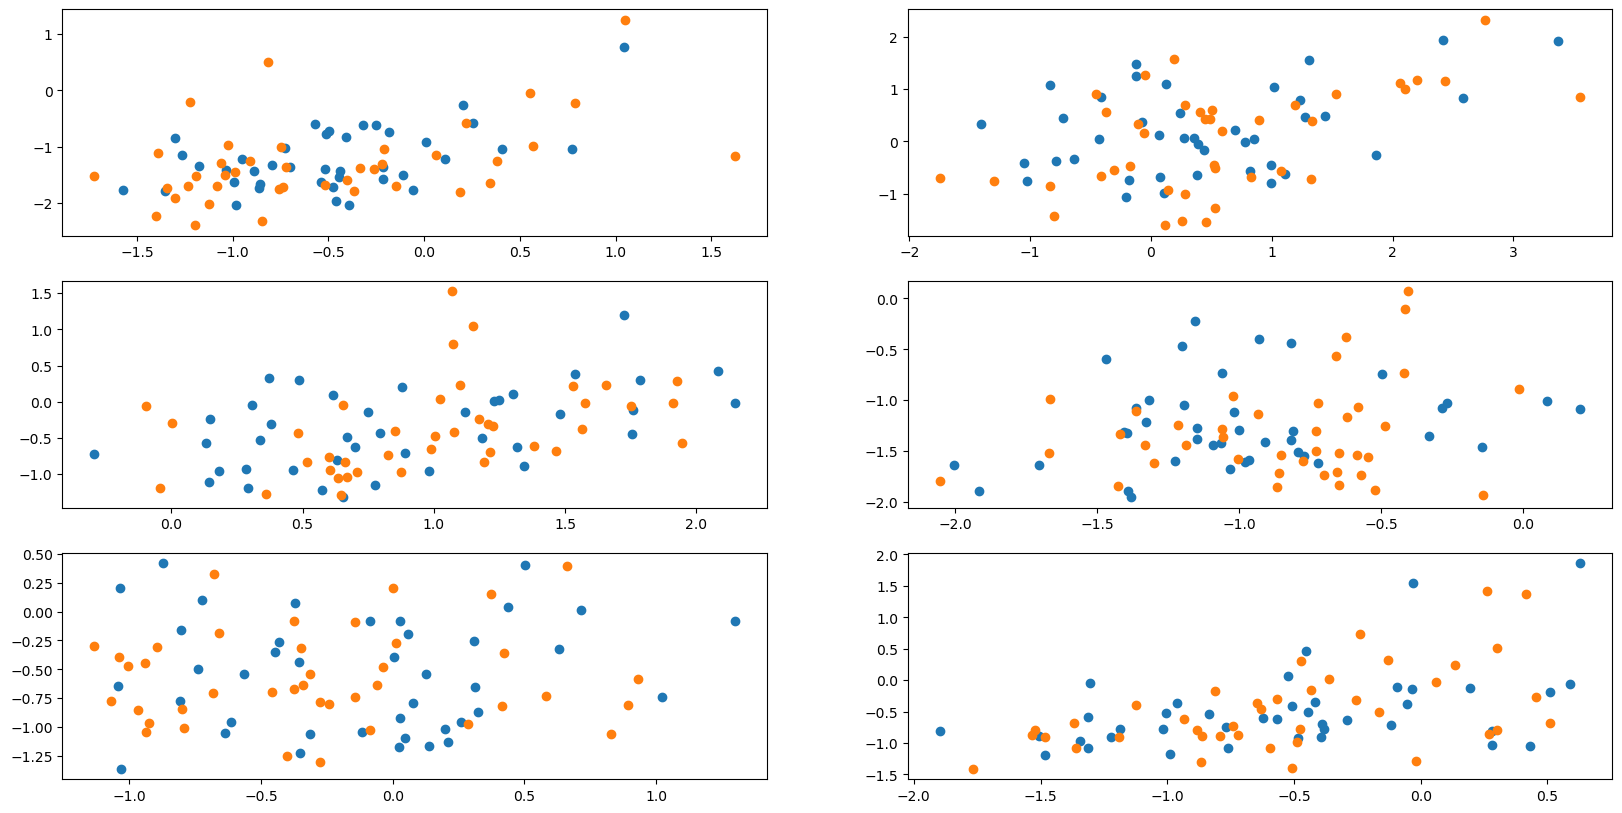

In [81]:
csp_features_plot(_csp_features,2,3)

### traditional classifiers

#### decision tree

In [41]:
decision_tree_results=pd.DataFrame(columns=['pre','post'],index=['P1','P2','P3'])

# dec=classifier(DecisionTreeClassifier,dec_tree_params)
# clf_result(decision_tree_results,dec,_csp_models)

dec=pipeline([
    # filter(70,40,256),
    # filter(0,30,256),
    csp(16),
    classifier(
        DecisionTreeClassifier,
        dec_tree_params
        )
    ])
results(decision_tree_results,dec)

decision_tree_results

[I 2022-10-10 11:58:34,270] A new study created in memory with name: no-name-c6d248ab-166d-4a7a-b458-128272e8a465


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:34,595] Trial 0 finished with value: 0.9375 and parameters: {'max_depth': 6, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 0 with value: 0.9375.
[I 2022-10-10 11:58:34,601] Trial 1 finished with value: 0.8854166666666666 and parameters: {'max_depth': 6, 'min_impurity_decrease': 0, 'criterion': 'gini', 'splitter': 'best'}. Best is trial 0 with value: 0.9375.
[I 2022-10-10 11:58:34,606] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 8, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 2 with value: 1.0.
[I 2022-10-10 11:58:34,612] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 14, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 2 with value: 1.0.
[I 2022-10-10 11:58:34,619] Trial 4 finished with value: 0.6666666666666666 and parameters: {'max_depth': 2, 'min_impurity_decrease': 0, 'criterion': 'gini', 'splitter': 'random

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:35,124] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 13, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:35,128] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 2, 'min_impurity_decrease': 0, 'criterion': 'gini', 'splitter': 'best'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:35,133] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 13, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:35,138] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 11, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:35,143] Trial 4 finished with value: 1.0 and parameters: {'max_depth': 11, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 0 with value: 1.

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:35,600] Trial 0 finished with value: 0.7395833333333334 and parameters: {'max_depth': 5, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 0 with value: 0.7395833333333334.
[I 2022-10-10 11:58:35,609] Trial 1 finished with value: 0.6041666666666666 and parameters: {'max_depth': 4, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 0 with value: 0.7395833333333334.
[I 2022-10-10 11:58:35,617] Trial 2 finished with value: 0.7708333333333334 and parameters: {'max_depth': 4, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 2 with value: 0.7708333333333334.
[I 2022-10-10 11:58:35,627] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 16, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 3 with value: 1.0.
[I 2022-10-10 11:58:35,634] Trial 4 finished with value: 0.71875 and parameters: {'max_depth': 2, '

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:36,115] Trial 3 finished with value: 0.7916666666666666 and parameters: {'max_depth': 5, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 1 with value: 0.9895833333333334.
[I 2022-10-10 11:58:36,122] Trial 4 finished with value: 0.6145833333333334 and parameters: {'max_depth': 3, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'random'}. Best is trial 1 with value: 0.9895833333333334.
[I 2022-10-10 11:58:36,130] Trial 5 finished with value: 1.0 and parameters: {'max_depth': 13, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 5 with value: 1.0.
[I 2022-10-10 11:58:36,139] Trial 6 finished with value: 0.875 and parameters: {'max_depth': 9, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'random'}. Best is trial 5 with value: 1.0.
[I 2022-10-10 11:58:36,147] Trial 7 finished with value: 0.6666666666666666 and parameters: {'max_depth': 2, 'min_impurity_decrease'

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:36,633] Trial 2 finished with value: 0.9583333333333334 and parameters: {'max_depth': 9, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:36,639] Trial 3 finished with value: 0.9375 and parameters: {'max_depth': 7, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:36,646] Trial 4 finished with value: 0.7291666666666666 and parameters: {'max_depth': 2, 'min_impurity_decrease': 0, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:36,652] Trial 5 finished with value: 1.0 and parameters: {'max_depth': 14, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:36,660] Trial 6 finished with value: 1.0 and parameters: {'max_depth': 12, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter':

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:37,132] Trial 0 finished with value: 0.8958333333333334 and parameters: {'max_depth': 6, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 0 with value: 0.8958333333333334.
[I 2022-10-10 11:58:37,139] Trial 1 finished with value: 0.9270833333333334 and parameters: {'max_depth': 7, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 1 with value: 0.9270833333333334.
[I 2022-10-10 11:58:37,146] Trial 2 finished with value: 0.8958333333333334 and parameters: {'max_depth': 6, 'min_impurity_decrease': 0, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 1 with value: 0.9270833333333334.
[I 2022-10-10 11:58:37,152] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 14, 'min_impurity_decrease': 0, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 3 with value: 1.0.
[I 2022-10-10 11:58:37,159] Trial 4 finished with value: 1.0 and parameters: {'max_depth': 14, 'min_impurity_

,pre,post
P1,0.8375,0.9375
P2,0.85,0.7875
P3,0.875,0.8875


#### SVC

In [42]:
SVC_results=pd.DataFrame(columns=['pre','post'],index=['P1','P2','P3'])
pSVCp=pipeline([
    # filter(70,40,256),
    # filter(0,30,256),
    csp(16),
    classifier(
        SVC,
        SVC_params
        )
    ])
results(SVC_results,pSVCp)
SVC_results

[I 2022-10-10 11:58:48,138] A new study created in memory with name: no-name-68b345ec-6d85-402c-8aa0-ca0fc6cac5d9


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:48,421] Trial 0 finished with value: 0.6875 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.6875.
[I 2022-10-10 11:58:48,428] Trial 1 finished with value: 0.6666666666666666 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.6875.
[I 2022-10-10 11:58:48,438] Trial 2 finished with value: 0.6875 and parameters: {'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.6875.
[I 2022-10-10 11:58:48,447] Trial 3 finished with value: 0.6875 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.6875.
[I 2022-10-10 11:58:48,459] Trial 4 finished with value: 0.6875 and parameters: {'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.6875.
[I 2022-10-10 11:58:48,471] Trial 5 finished with value: 0.6666666666666666 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.6875.
[I 2022-10-10 11:58:48,483] Trial 6 finished with valu

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:49,022] Trial 6 finished with value: 0.96875 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:49,027] Trial 7 finished with value: 0.96875 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:49,032] Trial 8 finished with value: 0.96875 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:58:49,037] Trial 9 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 1.0.


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:49,548] A new study created in memory with name: no-name-3cb015fa-f893-4e8e-b111-39c09c9ec27e
[I 2022-10-10 11:58:49,563] Trial 0 finished with value: 0.75 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.75.
[I 2022-10-10 11:58:49,572] Trial 1 finished with value: 0.75 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.75.
[I 2022-10-10 11:58:49,579] Trial 2 finished with value: 0.6666666666666666 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.75.
[I 2022-10-10 11:58:49,584] Trial 3 finished with value: 0.6875 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.75.
[I 2022-10-10 11:58:49,590] Trial 4 finished with value: 0.6875 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.75.
[I 2022-10-10 11:58:49,596] Trial 5 finished with value: 0.6875 and parameters: {'kernel': 'linear', 'gamma': 'scale'}.

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:50,015] Trial 1 finished with value: 0.6666666666666666 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.7083333333333334.
[I 2022-10-10 11:58:50,024] Trial 2 finished with value: 0.65625 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7083333333333334.
[I 2022-10-10 11:58:50,054] Trial 3 finished with value: 0.6979166666666666 and parameters: {'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.7083333333333334.
[I 2022-10-10 11:58:50,064] Trial 4 finished with value: 0.6979166666666666 and parameters: {'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.7083333333333334.
[I 2022-10-10 11:58:50,075] Trial 5 finished with value: 0.65625 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7083333333333334.
[I 2022-10-10 11:58:50,086] Trial 6 finished with value: 0.6666666666666666 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best i

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:50,584] Trial 6 finished with value: 0.7916666666666666 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.8333333333333334.
[I 2022-10-10 11:58:50,591] Trial 7 finished with value: 0.78125 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 1 with value: 0.8333333333333334.
[I 2022-10-10 11:58:50,597] Trial 8 finished with value: 0.7916666666666666 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.8333333333333334.
[I 2022-10-10 11:58:50,604] Trial 9 finished with value: 0.7916666666666666 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.8333333333333334.
[I 2022-10-10 11:58:51,072] A new study created in memory with name: no-name-b81f3619-7888-4283-92b8-beefa130ae9e


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:58:51,080] Trial 0 finished with value: 0.6145833333333334 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.6145833333333334.
[I 2022-10-10 11:58:51,090] Trial 1 finished with value: 0.6145833333333334 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.6145833333333334.
[I 2022-10-10 11:58:51,095] Trial 2 finished with value: 0.5833333333333334 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.6145833333333334.
[I 2022-10-10 11:58:51,102] Trial 3 finished with value: 0.6145833333333334 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.6145833333333334.
[I 2022-10-10 11:58:51,111] Trial 4 finished with value: 0.6145833333333334 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.6145833333333334.
[I 2022-10-10 11:58:51,120] Trial 5 finished with value: 0.6145833333333334 and parameters: {'kernel': 'rbf', 'gam

,pre,post
P1,0.625,0.9625
P2,0.675,0.625
P3,0.825,0.625


#### NuSVC

In [43]:
NuSVC_results=pd.DataFrame(columns=['pre','post'],index=['P1','P2','P3'])
NuSVC_p=pipeline([
    # filter(70,40,256),
    filter(0,30,256),
    csp(16),
    classifier(
        NuSVC,
        NuSVC_params
        )
    ])
results(NuSVC_results,NuSVC_p)
NuSVC_results

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed:    1.2s finished
[I 2022-10-10 11:59:00,219] A new study created in memory with name: no-name-c359ff93-ca07-4647-8335-ba6d176d32fa


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:00,226] Trial 0 finished with value: 0.84375 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.84375.
[I 2022-10-10 11:59:00,230] Trial 1 finished with value: 0.84375 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.84375.
[I 2022-10-10 11:59:00,235] Trial 2 finished with value: 0.84375 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.84375.
[I 2022-10-10 11:59:00,240] Trial 3 finished with value: 0.84375 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.84375.
[I 2022-10-10 11:59:00,245] Trial 4 finished with value: 0.78125 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.84375.
[I 2022-10-10 11:59:00,249] Trial 5 finished with value: 0.84375 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.84375.
[I 2022-10-10 11:59:00,254] Trial 6 finished with value: 0.78125 an

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed:    1.2s finished
[I 2022-10-10 11:59:03,263] A new study created in memory with name: no-name-68110eb0-db31-4714-bf54-e71f20543202
[I 2022-10-10 11:59:03,272] Trial 0 finished with value: 0.9895833333333334 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.9895833333333334.
[I 2022-10-10 11:59:03,279] Trial 1 finished with value: 0.9895833333333334 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.989583

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:03,294] Trial 3 finished with value: 0.9791666666666666 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.9895833333333334.
[I 2022-10-10 11:59:03,300] Trial 4 finished with value: 0.90625 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.9895833333333334.
[I 2022-10-10 11:59:03,307] Trial 5 finished with value: 0.9791666666666666 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.9895833333333334.
[I 2022-10-10 11:59:03,314] Trial 6 finished with value: 0.90625 and parameters: {'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.9895833333333334.
[I 2022-10-10 11:59:03,325] Trial 7 finished with value: 0.9895833333333334 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.9895833333333334.
[I 2022-10-10 11:59:03,335] Trial 8 finished with value: 0.90625 and parameters: {'kernel': 'poly', 'gamma': 'scale'}. Best is trial

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed:    1.3s finished
[I 2022-10-10 11:59:06,355] A new study created in memory with name: no-name-b85410e5-df2b-4018-bae8-93e19e676e4b
[I 2022-10-10 11:59:06,365] Trial 0 finished with value: 0.4895833333333333 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.4895833333333333.


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:06,374] Trial 1 finished with value: 0.4895833333333333 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.4895833333333333.
[I 2022-10-10 11:59:06,514] Trial 2 finished with value: 0.8125 and parameters: {'kernel': 'poly', 'gamma': 'scale'}. Best is trial 2 with value: 0.8125.
[I 2022-10-10 11:59:06,521] Trial 3 finished with value: 0.4895833333333333 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.8125.
[I 2022-10-10 11:59:06,527] Trial 4 finished with value: 0.4895833333333333 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0.8125.
[I 2022-10-10 11:59:06,536] Trial 5 finished with value: 0.4895833333333333 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.8125.
[I 2022-10-10 11:59:06,543] Trial 6 finished with value: 0.4895833333333333 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.81

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz


[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    0.9s finished



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed:    1.3s finished


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:09,712] A new study created in memory with name: no-name-f6fc00fa-50c3-481b-a4c5-df108352942d
[I 2022-10-10 11:59:09,743] Trial 0 finished with value: 0.75 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.75.
[I 2022-10-10 11:59:09,755] Trial 1 finished with value: 0.78125 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.78125.
[I 2022-10-10 11:59:09,805] Trial 2 finished with value: 0.75 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 1 with value: 0.78125.
[I 2022-10-10 11:59:09,816] Trial 3 finished with value: 0.7916666666666666 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 3 with value: 0.7916666666666666.
[I 2022-10-10 11:59:09,823] Trial 4 finished with value: 0.4583333333333333 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 3 with value: 0.7916666666666666.
[I 2022-10-10 11:59:09,831] Trial 5 finished with value: 0.4583333333333333

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz



[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    0.9s finished


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed:    1.2s finished


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:12,814] A new study created in memory with name: no-name-3c94ba14-4a45-4808-8bde-5c03990f8cf7
[I 2022-10-10 11:59:12,821] Trial 0 finished with value: 0.7916666666666666 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.7916666666666666.
[I 2022-10-10 11:59:12,831] Trial 1 finished with value: 0.8229166666666666 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.8229166666666666.
[I 2022-10-10 11:59:12,839] Trial 2 finished with value: 0.7916666666666666 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 1 with value: 0.8229166666666666.
[I 2022-10-10 11:59:12,846] Trial 3 finished with value: 0.7604166666666666 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.8229166666666666.
[I 2022-10-10 11:59:12,853] Trial 4 finished with value: 0.7604166666666666 and parameters: {'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.82291666666666

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.0s finished


- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed:    1.2s finished
[I 2022-10-10 11:59:15,823] A new study created in memory with name: no-name-be3674d4-f1b5-436e-b33a-3f3b04b36a5c
[I 2022-10-10 11:59:15,829] Trial 0 finished with value: 0.5833333333333334 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.5833333333333334.


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:15,838] Trial 1 finished with value: 0.84375 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.84375.
[I 2022-10-10 11:59:15,873] Trial 2 finished with value: 0.7916666666666666 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 1 with value: 0.84375.
[I 2022-10-10 11:59:15,883] Trial 3 finished with value: 0.84375 and parameters: {'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.84375.
[I 2022-10-10 11:59:15,890] Trial 4 finished with value: 0.5833333333333334 and parameters: {'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.84375.
[I 2022-10-10 11:59:15,901] Trial 5 finished with value: 0.8645833333333334 and parameters: {'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 5 with value: 0.8645833333333334.
[I 2022-10-10 11:59:15,957] Trial 6 finished with value: 0.7916666666666666 and parameters: {'kernel': 'poly', 'gamma': 'auto'}. Best is trial 5 with value: 0.8645833333333334.
[I 

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 227 samples (0.443 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:    1.0s finished


,pre,post
P1,0.8125,0.9875
P2,0.7625,0.75
P3,0.75,0.775


#### random forest

In [44]:
random_forest_results=pd.DataFrame(columns=['pre','post'],index=['P1','P2','P3'])
rndfor=pipeline([
        # filter(70,40,256),
        # filter(0,30,256),
        csp(16),
            classifier(
                RandomForestClassifier,
                rand_for_params
                )
        ])
results(random_forest_results,rndfor)
random_forest_results

[I 2022-10-10 11:59:40,848] A new study created in memory with name: no-name-bc4c0f00-5c7a-463a-8611-1c567be06636


(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:41,226] Trial 0 finished with value: 0.8125 and parameters: {'max_depth': 3, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.8125.
[I 2022-10-10 11:59:41,534] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 6, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 1 with value: 1.0.
[I 2022-10-10 11:59:41,946] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 10, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 1 with value: 1.0.
[I 2022-10-10 11:59:42,281] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 12, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 1 with value: 1.0.
[I 2022-10-10 11:59:42,634] Trial 4 finished with value: 0.9895833333333334 and parameters: {'max_depth': 6, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 1 with value: 1.0.
[I 2022-10-10 11:59:43,047] Trial 5 finished with value: 1.0 and parameters: {'max

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:45,173] A new study created in memory with name: no-name-f6ca0f96-df83-4c77-9345-f3eae9fe534e
[I 2022-10-10 11:59:45,490] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 5, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:45,821] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 11, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:46,154] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 9, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:46,527] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 5, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:46,835] Trial 4 finished with value: 1.0 and parameters: {'max_depth': 16, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with 

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:49,621] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 7, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:49,849] Trial 1 finished with value: 0.8854166666666666 and parameters: {'max_depth': 4, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:50,297] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 8, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:50,566] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 17, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:50,941] Trial 4 finished with value: 1.0 and parameters: {'max_depth': 14, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:51,278] Trial 5 finished with value: 1.0 and parameters: {'max_depth': 

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:53,792] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 14, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:54,064] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 7, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:54,475] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 17, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:54,731] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 12, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:55,160] Trial 4 finished with value: 1.0 and parameters: {'max_depth': 8, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:55,403] Trial 5 finished with value: 1.0 and parameters: {'max_depth': 10, 'min_im

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 11:59:57,729] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 10, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:58,093] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 15, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:58,363] Trial 2 finished with value: 1.0 and parameters: {'max_depth': 13, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:58,742] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 16, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:58,976] Trial 4 finished with value: 1.0 and parameters: {'max_depth': 15, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 11:59:59,391] Trial 5 finished with value: 0.9375 and parameters: {'max_depth': 4, 'min_i

(96,) (96, 16, 2048) (96, 16, 16)


[I 2022-10-10 12:00:01,611] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 10, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 12:00:01,997] Trial 1 finished with value: 1.0 and parameters: {'max_depth': 14, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 12:00:02,257] Trial 2 finished with value: 0.78125 and parameters: {'max_depth': 2, 'min_impurity_decrease': 0, 'criterion': 'gini'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 12:00:02,629] Trial 3 finished with value: 1.0 and parameters: {'max_depth': 11, 'min_impurity_decrease': 0, 'criterion': 'entropy'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 12:00:02,936] Trial 4 finished with value: 0.9479166666666666 and parameters: {'max_depth': 4, 'min_impurity_decrease': 0, 'criterion': 'log_loss'}. Best is trial 0 with value: 1.0.
[I 2022-10-10 12:00:03,240] Trial 5 finished with value: 1.0 and parameters: {'

,pre,post
P1,0.8625,0.95
P2,0.85,0.8125
P3,0.8875,0.85


#### result

In [113]:
result=pd.DataFrame()
pre=decision_tree_results['pre'].to_list()+NuSVC_results['pre'].to_list()+random_forest_results['pre'].to_list()
post_r=decision_tree_results['post'].to_list()+NuSVC_results['post'].to_list()+random_forest_results['post'].to_list()
result['pre']=pre
result['post']=post_r
result['subject']=['P1','P2','P3']*3
result['clf']=['Decision Tree']*3 + ['NuSVC']*3 +['Random Forest']*3
result

,pre,post,subject,clf
0,0.8375,0.9375,P1,Decision Tree
1,0.8500,0.7875,P2,Decision Tree
2,0.8750,0.8875,P3,Decision Tree
3,0.8125,0.9875,P1,NuSVC
4,0.7625,0.7500,P2,NuSVC
5,0.7500,0.7750,P3,NuSVC
6,0.8625,0.9500,P1,Random Forest
7,0.8500,0.8125,P2,Random Forest
8,0.8875,0.8500,P3,Random Forest


In [110]:
files=open('optuna.sav','wb')
pickle.dump(result,files)
files.close()

In [114]:
result.loc[result['subject']=='P1'][:]['pre']

,pre,post,subject,clf
0,0.8375,0.9375,P1,Decision Tree
3,0.8125,0.9875,P1,NuSVC
6,0.8625,0.9500,P1,Random Forest


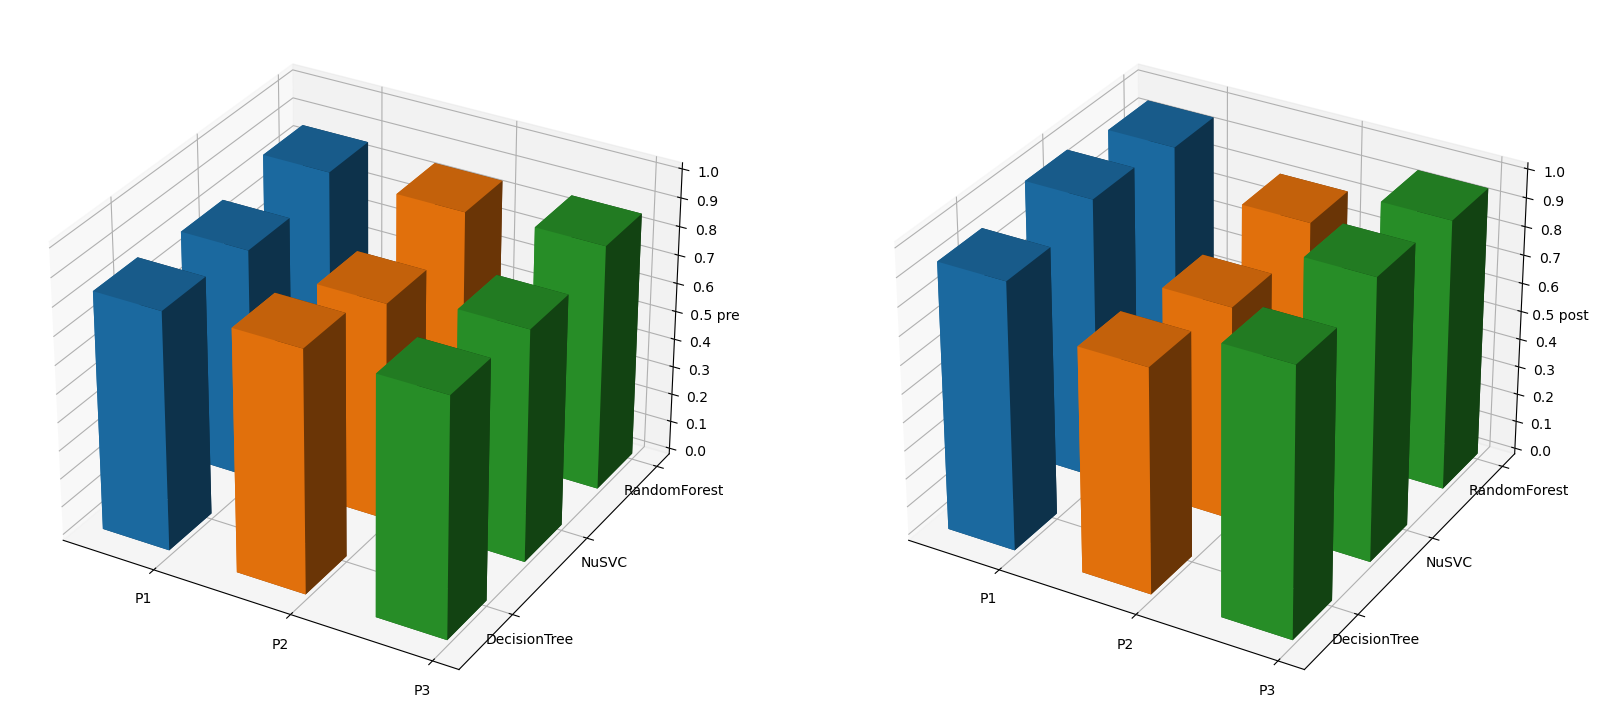

In [143]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x = [0,0,0]  # x coordinates of each bar
y = [0,1,2]  # y coordinates of each bar
z = [0,0,0]  # z coordinates of each bar
dx = [0.5, 0.5, 0.5]  # Width of each bar
dy = [0.5, 0.5, 0.5]  # Depth of each bar
dz=result.loc[result['subject']=='P1'][:]['pre'].to_list()
ax1.bar3d(x,y,z,dx,dy,dz)

x = [1,1,1]  # x coordinates of each bar
y = [0,1,2]  # y coordinates of each bar
z = [0,0,0]  # z coordinates of each bar
dx = [0.5, 0.5, 0.5]  # Width of each bar
dy = [0.5, 0.5, 0.5]  # Depth of each bar
dz=result.loc[result['subject']=='P2'][:]['pre'].to_list()
ax1.bar3d(x,y,z,dx,dy,dz)

x = [2,2,2]  # x coordinates of each bar
y = [0,1,2]  # y coordinates of each bar
z = [0,0,0]  # z coordinates of each bar
dx = [0.5, 0.5, 0.5]  # Width of each bar
dy = [0.5, 0.5, 0.5]  # Depth of each bar
dz=result.loc[result['subject']=='P1'][:]['pre'].to_list()
ax1.bar3d(x,y,z,dx,dy,dz)

ax1.set_xticks([0.5,1.5,2.5],['P1','P2','P3'])
ax1.set_yticks([0.5,1.5,2.5],['DecisionTree','NuSVC','RandomForest'])
ax1.set_zticks(
    [0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
    [0.0,.1,.2,.3,.4,'      0.5 pre',.6,.7,.8,.9,1.0]
)


x = [0,0,0]  # x coordinates of each bar
y = [0,1,2]  # y coordinates of each bar
z = [0,0,0]  # z coordinates of each bar
dx = [0.5, 0.5, 0.5]  # Width of each bar
dy = [0.5, 0.5, 0.5]  # Depth of each bar
dz=result.loc[result['subject']=='P1'][:]['post'].to_list()
ax2.bar3d(x,y,z,dx,dy,dz)

x = [1,1,1]  # x coordinates of each bar
y = [0,1,2]  # y coordinates of each bar
z = [0,0,0]  # z coordinates of each bar
dx = [0.5, 0.5, 0.5]  # Width of each bar
dy = [0.5, 0.5, 0.5]  # Depth of each bar
dz=result.loc[result['subject']=='P2'][:]['post'].to_list()
ax2.bar3d(x,y,z,dx,dy,dz)

x = [2,2,2]  # x coordinates of each bar
y = [0,1,2]  # y coordinates of each bar
z = [0,0,0]  # z coordinates of each bar
dx = [0.5, 0.5, 0.5]  # Width of each bar
dy = [0.5, 0.5, 0.5]  # Depth of each bar
dz=result.loc[result['subject']=='P1'][:]['post'].to_list()
ax2.bar3d(x,y,z,dx,dy,dz)

ax2.set_xticks([0.5,1.5,2.5],['P1','P2','P3'])
ax2.set_yticks([0.5,1.5,2.5],['DecisionTree','NuSVC','RandomForest'])
ax2.set_zticks(
    [0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
    [0.0,.1,.2,.3,.4,'      0.5 post',.6,.7,.8,.9,1.0]
)


# Neural networks

In [9]:
from sklearn.neural_network import MLPClassifier,BernoulliRBM

#### stft

In [10]:
import tensorflow as tf
from keras import datasets, layers, models

In [189]:
class CNN:
    def __init__(self,h,w,ch):
        self.model=models.Sequential()
        self.model.add(layers.Conv2D(16, (2,2), activation='relu', input_shape=(h,w,ch)))
        self.model.add(layers.MaxPooling2D((2,2)))
        self.model.add(layers.Conv2D(16, (2,2), activation='relu'))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (2, 2), activation='relu'))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(64, activation='relu'))
        self.model.add(layers.Dense(10))
        self.model.add(layers.Dense(2))
        self.model.add(layers.Dense(1))

    def summary(self):
        return self.model.summary()

    def compile(self,optimizer,loss,metrics):
        self.model.compile(optimizer,loss,metrics=[metrics])

    def history(self,Xtrain,ytrain,Xtest,ytest,n_epochs):
        return self.model.fit(Xtrain,ytrain,epochs=n_epochs,validation_data=(Xtest,ytest))

In [169]:
X_train=dataset['P1']['pre']['train']['X']
y_train=dataset['P1']['pre']['train']['y']
X_test=dataset['P1']['pre']['test']['X']
y_test=dataset['P1']['pre']['test']['y']

In [170]:
X_train=stft(8).transform(X_train)
X_test=stft(8).transform(X_test)

In [171]:
X_test.shape

(80, 512, 16, 5)

In [192]:
stft_cnn=CNN(512,16,5)

In [193]:
stft_cnn.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 511, 15, 16)       336       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 255, 7, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 254, 6, 16)        1040      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 127, 3, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 126, 2, 64)        4160      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 63, 1, 64)      

In [194]:
stft_cnn.compile('adam',tf.keras.losses.BinaryCrossentropy(),'accuracy')
history=stft_cnn.history(X_train,y_train,X_test,y_test,10)

Epoch 1/10
3/3 [==============================] - 3s 641ms/step - loss: 7.9462 - accuracy: 0.4750 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 2s 676ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 540ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 397ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 360ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 367ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 1s 556ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 8/10
3/3 [====

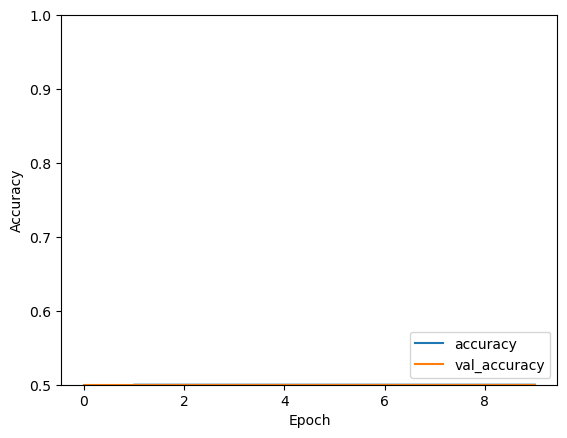

In [195]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#### ICA + CNN

In [113]:
_ica_pipeline=pipeline([
    filter(0,30,256),
    ica(n_comp=4),
    # flatten()
])

# _ica_models=train_features_models(_ica_pipeline)
# _ica_features=get_test_features(_ica_pipeline)

#### params

In [16]:
MLP_params={
    'hidden_layer_sizes':[list(range(dt*fs,1,-1)),list(range(dt*fs,1,-2))],
    'activation':['identity','relu','tanh','logistic'],
    'solver':['lbfgs','sgd','adam'],
    'learning_rate':['constant','invscaling','adaptive']
}

#### MLP

In [19]:
mlp_results=pd.DataFrame(columns=['pre','post'],index=['P1','P2','P3'])
mlp=pipeline([
    # filter(0,30,256),
    flatten(),
    classifier(
        MLPClassifier,
        MLP_params
    )
])
results(mlp_results,mlp)

In [643]:
mlp_results

,pre,post
P1,0.4625,0.8125
P2,0.4875,0.7
P3,0.4875,0.5875


#### RBM

#### next